# Downstream analysis pySCENIC

Downstream analysis using the loom file generated from [this notebook]("./pySCENIC_NK_mm.ipynb")

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pyscenic.utils import load_motifs
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

import warnings
warnings.filterwarnings('ignore')

In [2]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = "Results/75/mm_scenic_integrated-output.loom"

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)



## Extract relevant data from the integrated loom file


In [4]:


# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)



In [5]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)



In [6]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.new_label, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.label, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.percent_mt, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.batch, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'new_label',
 'label',
 'percent_mt',
 'nGene',
 'nUMI',
 'batch']


In [7]:
# capture embeddings:

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

dr = pd.DataFrame()
dr.index = drx.index
dr["X"] = drx
dr["Y"] = dry




In [8]:
lf.close()

### Using anndata

In [9]:
adata = sc.read( f_final_loom, validate=False)

# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [10]:
adata.obsm["X_umap"] = np.array(dr)

In [11]:
sc._utils.sanitize_anndata( adata )

In [12]:
# load the regulons from a file using the load_signatures function
sig = load_signatures('Results/75/reg_mm.csv')
adata = add_scenic_metadata(adata, auc_mtx, sig)


Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [13]:
df_motifs = load_motifs('Results/75/reg_mm.csv')

In [14]:
# Z-score area under the curve for selected regulons
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)



In [15]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f


def TF_activity(label, n):
    rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot[label] )
    print(rss_cellType)
    
    cats = sorted(list(set(cellAnnot[label])))

    fig = plt.figure(figsize=(15, 8))
    for c,num in zip(cats, range(1,len(cats)+1)):
        x=rss_cellType.T[c]
        ax = fig.add_subplot(1,3,num)
        plot_rss(rss_cellType, c, top_n=n, max_n=None, ax=ax)
        ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
        for t in ax.texts:
            t.set_fontsize(12)
        ax.set_ylabel('')
        ax.set_xlabel('')
        adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )

    fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
    fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
    plt.tight_layout()
    plt.rcParams.update({
        'figure.autolayout': True,
            'figure.titlesize': 'large' ,
            'axes.labelsize': 'medium',
            'axes.titlesize':'large',
            'xtick.labelsize':'medium',
            'ytick.labelsize':'medium'
            })
    #plt.savefig("test_cell-state-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
    plt.show()
    
    # top regulons for each cell type
    topreg = []
    for i,c in enumerate(cats):
        topreg.extend(
            list(rss_cellType.T[c].sort_values(ascending=False)[:n].index)
        )
    topreg = list(set(topreg))

    colors = sns.color_palette('bright',n_colors=len(cats) )
    colorsd = dict( zip( cats, colors ))
    colormap = [ colorsd[x] for x in cellAnnot[label] ]

    sns.set()
    sns.set(font_scale=0.8)
    fig = palplot( colors, cats, size=2.0)

    sns.set(font_scale=1.2)
    g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
        yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
        cmap="YlGnBu", figsize=(21,16) )
    g.cax.set_visible(True)
    g.ax_heatmap.set_ylabel('')
    g.ax_heatmap.set_xlabel('')

    means = round(rss_cellType.T.mean(),3)
    means = means.rename("mean")
    sd = round(rss_cellType.T.std(),3)
    sd = sd.rename("StDev")
    ratio = round(adata.obs[label].value_counts()/adata.n_obs,3)
    ratio = ratio.rename("Ratio")
    specs = pd.concat([means,sd,ratio],axis=1)
    print(specs)
    
    
    return rss_cellType



In [16]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

,ARID3A_(+),ARNT_(+),ARNTL_(+),ASCL2_(+),ATF1_(+),ATF2_(+),ATF3_(+),ATF4_(+),ATF5_(+),ATF7_(+),...,ZNF654_(+),ZNF707_(+),ZNF708_(+),ZNF740_(+),ZNF75A_(+),ZNF770_(+),ZNF787_(+),ZNF814_(+),ZNF836_(+),ZNF91_(+)
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1,1,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
MGUS_CD138nCD45p_2_TTGGCAACAAGGACTG-1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
MGUS_CD138nCD45p_3_AAATGCCCAAGGTTTC-1,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
MGUS_CD138nCD45p_3_AACTGGTGTCAAGCGA-1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
MGUS_CD138nCD45p_3_AAGCCGCCAGTGGGAT-1,1,0,1,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,1,1


In [17]:
def AUC_plot(rss_cellType):
    # top regulons for each cell type
    topreg = []
    for i,c in enumerate(rss_cellType.T):
        topreg = rss_cellType.loc[c].sort_values(ascending=False).index.to_list()[:5]
        topreg = list(set(topreg))
        
        fig, axs = plt.subplots(1, 5, figsize=(12, 4), dpi=150, sharey=False)
        for i,ax in enumerate(axs):
            sns.distplot(auc_mtx[ topreg[i] ], ax=ax, norm_hist=True, bins=100)
            ax.plot( [ auc_thresholds[ topreg[i] ] ]*2, ax.get_ylim(), 'r:')
            ax.title.set_text( topreg[i] )
            ax.set_xlabel('')

        fig.suptitle(c)
        fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
        fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

        fig.tight_layout()

              ARID3A_(+)  ARNT_(+)  ARNTL_(+)  ASCL2_(+)  ATF1_(+)  ATF2_(+)  \
NK exhausted    0.410298  0.457636   0.402698   0.438495  0.514531  0.507752   
NK resident     0.434787  0.424538   0.433516   0.382657  0.532171  0.482447   

              ATF3_(+)  ATF4_(+)  ATF5_(+)  ATF7_(+)  ...  ZNF654_(+)  \
NK exhausted  0.541202  0.531387  0.458454  0.373397  ...    0.406956   
NK resident   0.526077  0.532175  0.523280  0.333144  ...    0.375285   

              ZNF707_(+)  ZNF708_(+)  ZNF740_(+)  ZNF75A_(+)  ZNF770_(+)  \
NK exhausted    0.442751    0.469451    0.467040    0.291393    0.430716   
NK resident     0.444104    0.446898    0.506928    0.284727    0.506553   

              ZNF787_(+)  ZNF814_(+)  ZNF836_(+)  ZNF91_(+)  
NK exhausted    0.450461    0.355192    0.360426   0.484388  
NK resident     0.417950    0.388379    0.431059   0.472560  

[2 rows x 235 columns]


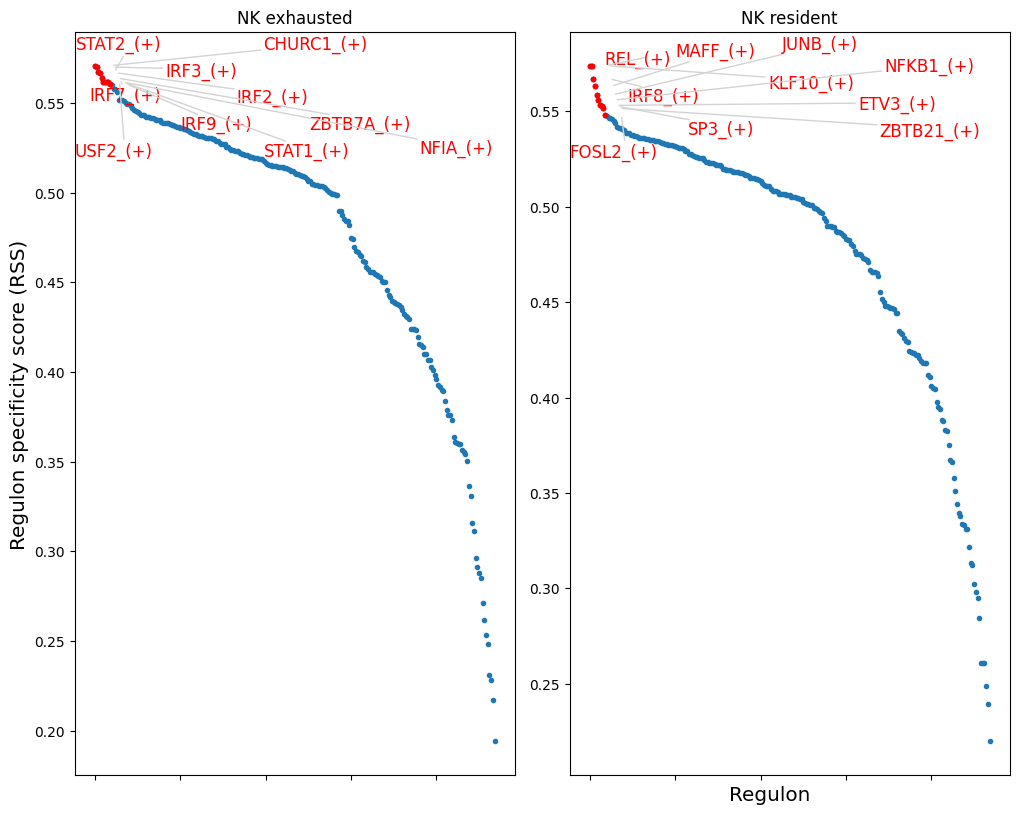

               mean  StDev  Ratio
NK exhausted  0.478  0.078   0.51
NK resident   0.478  0.072   0.49


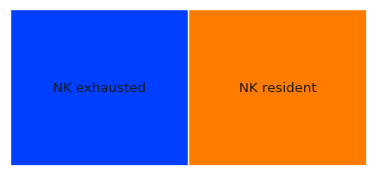

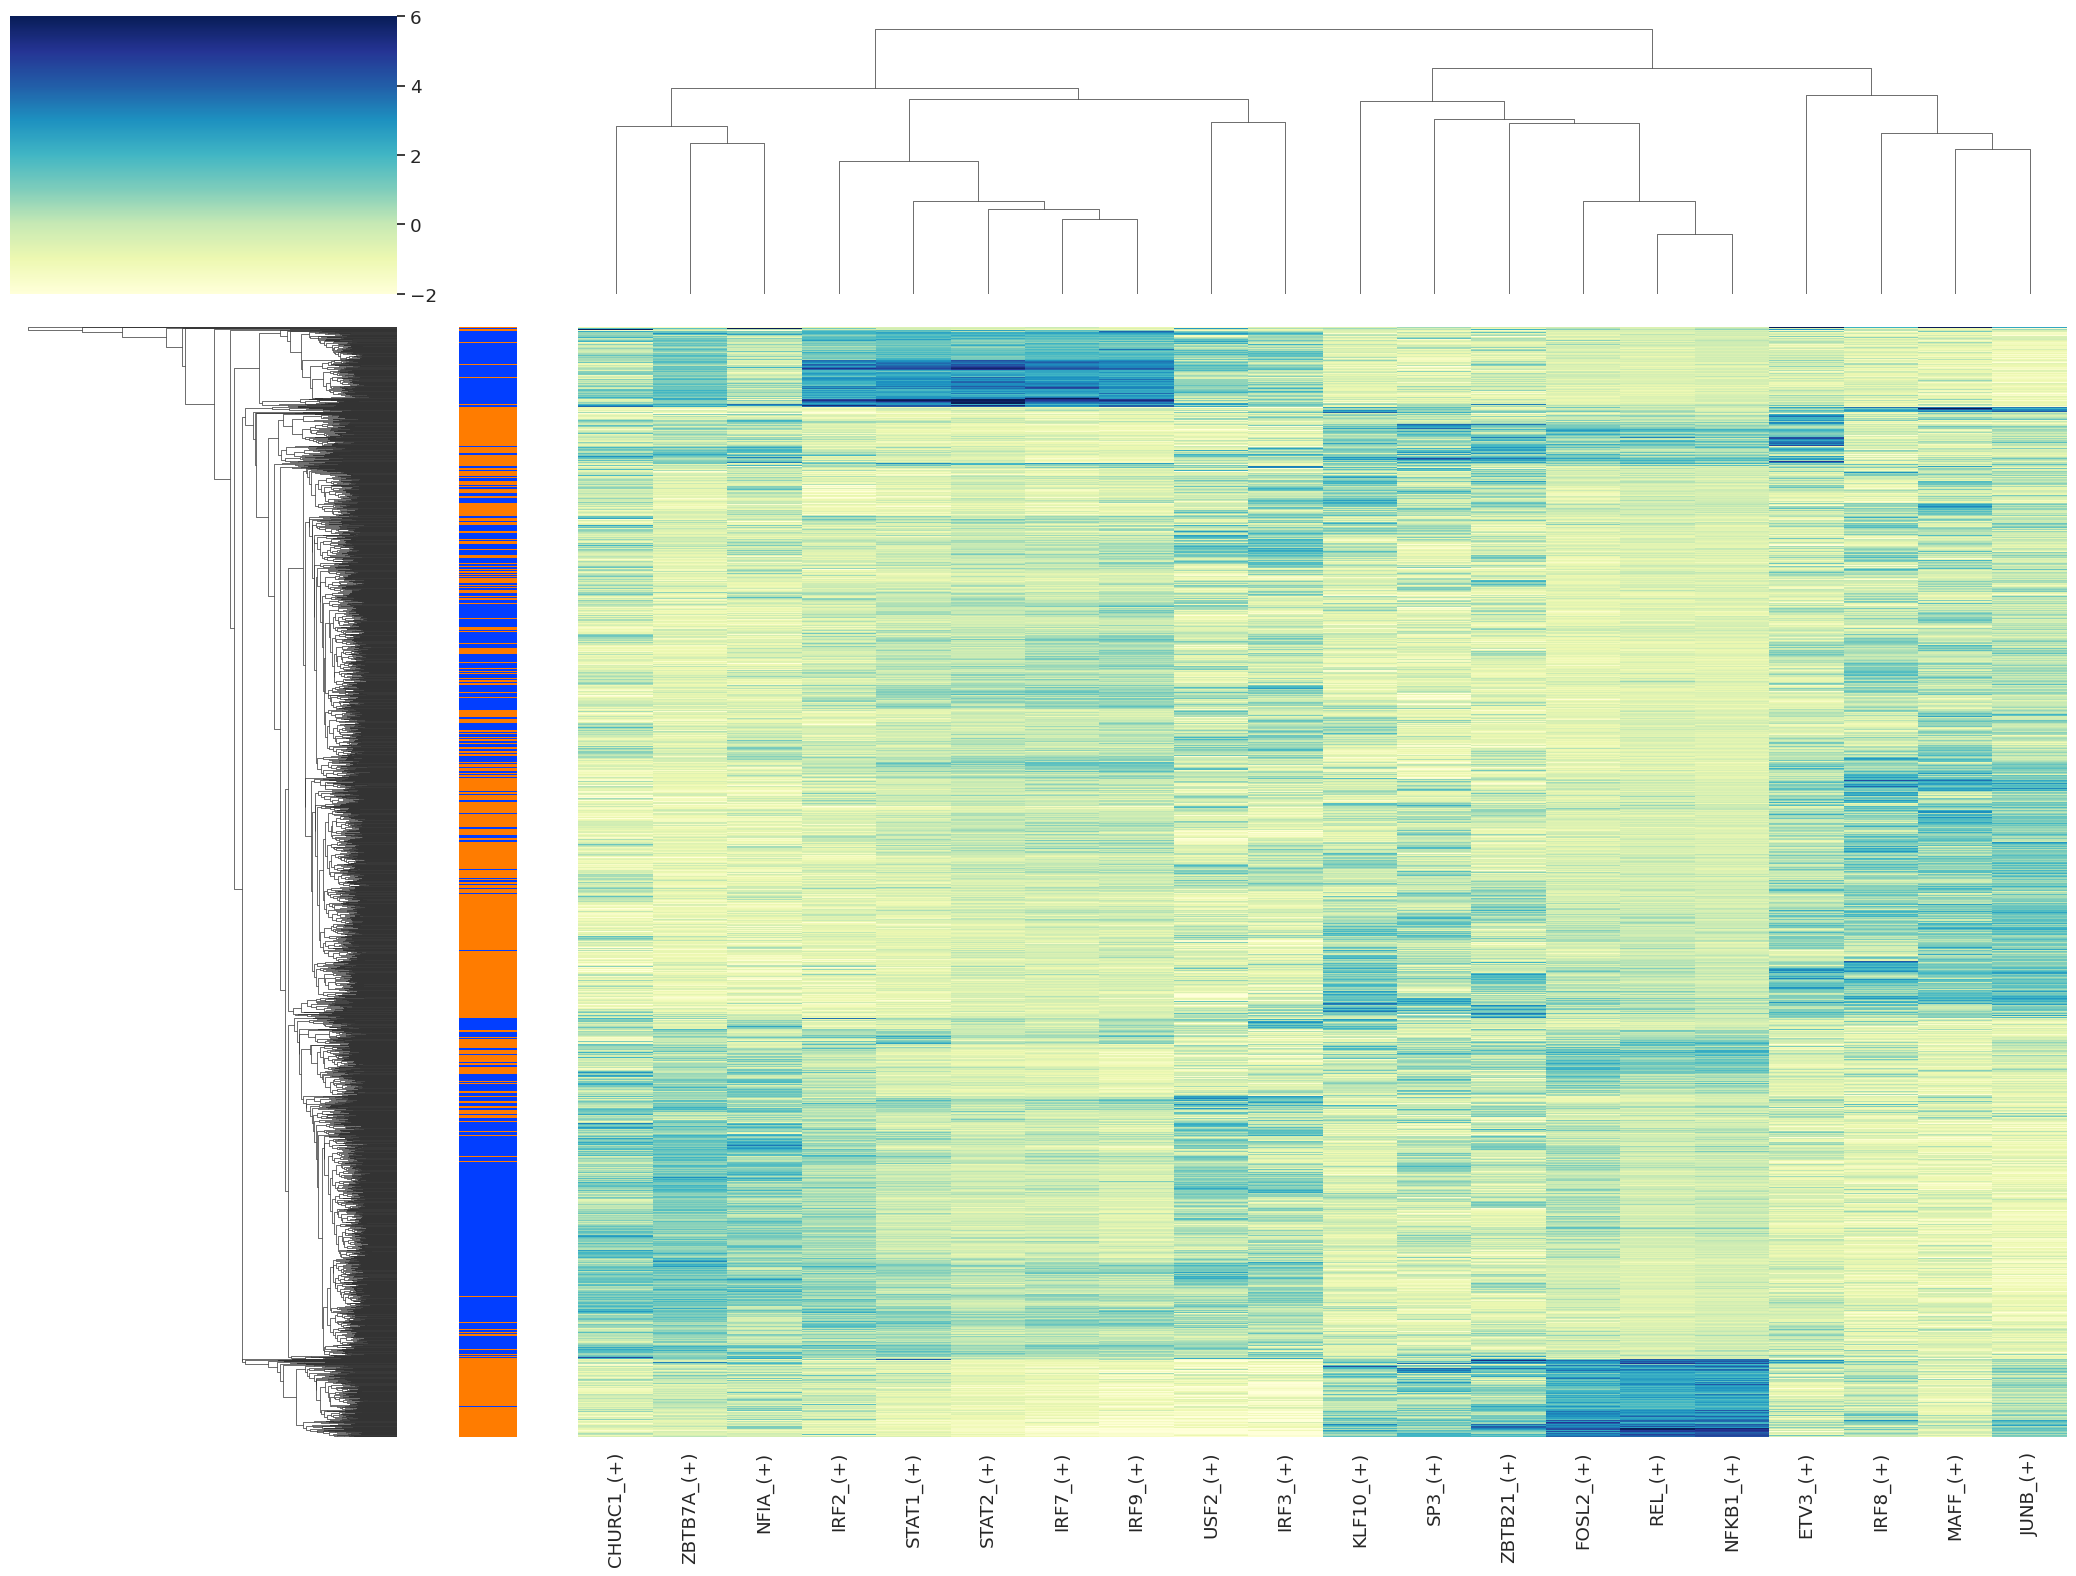

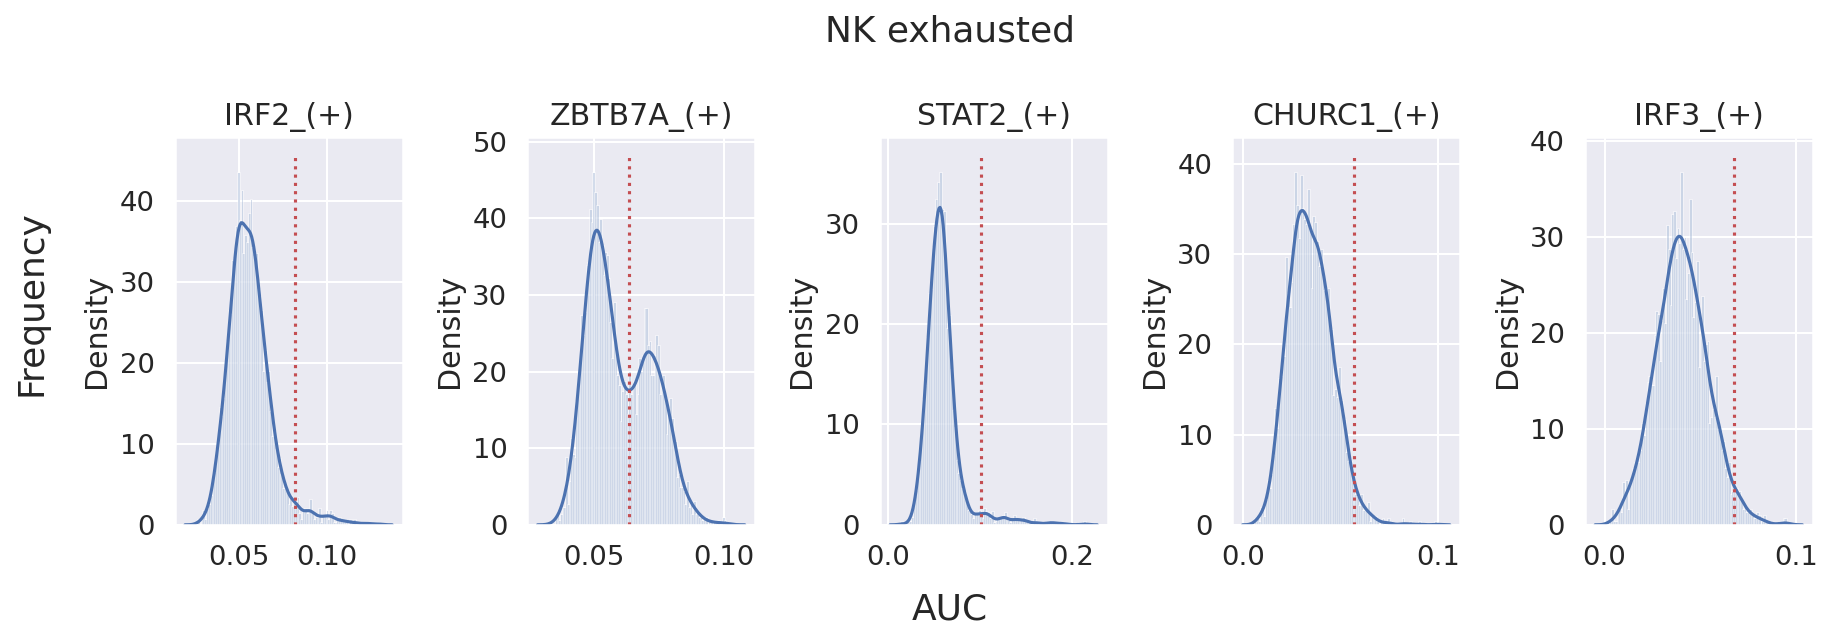

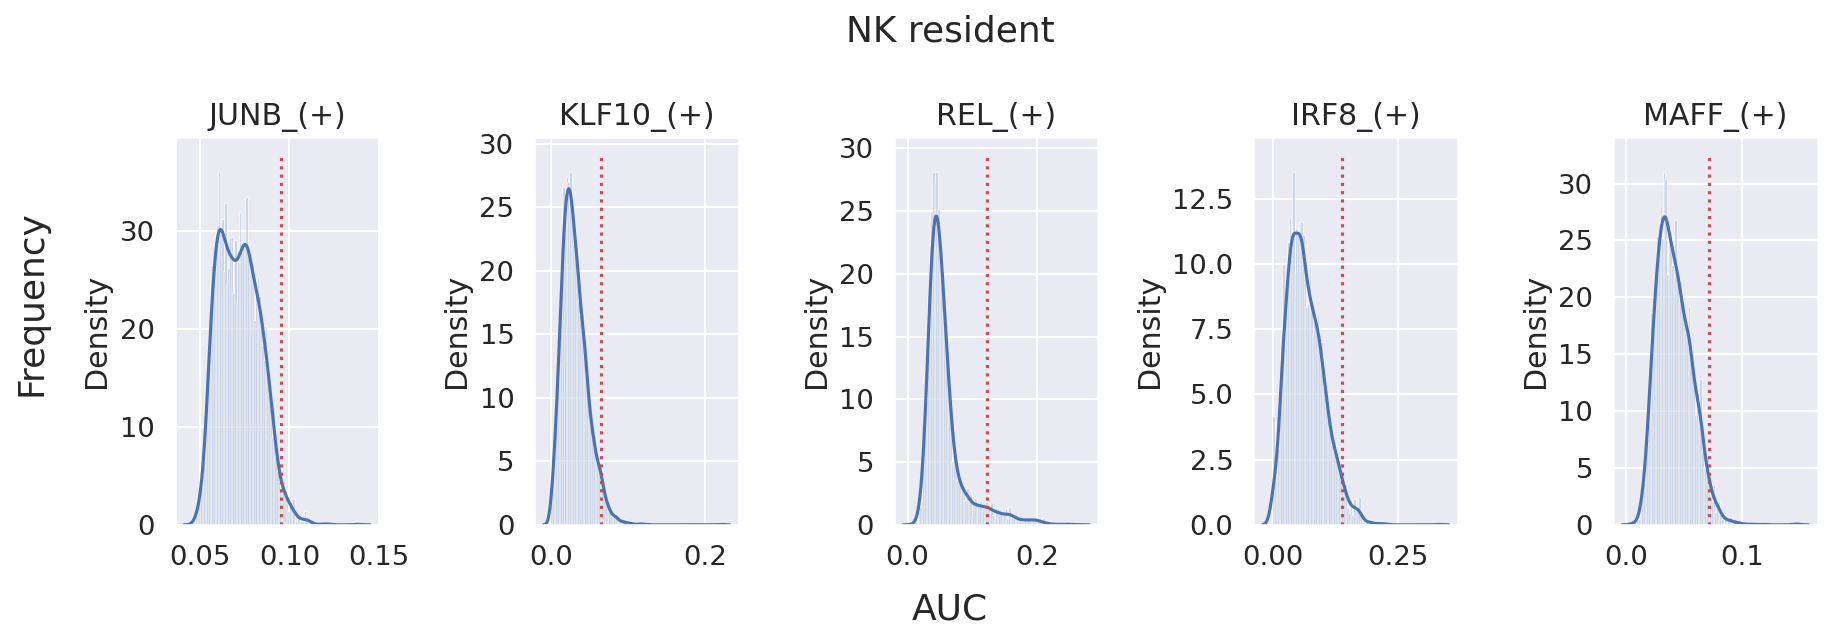

In [18]:
rss_cellType = TF_activity("new_label", 10)
AUC_plot(rss_cellType)

In [19]:

def fill_dict(scores, label, threshold):
    regulons_dict = {}
    myseries = scores.loc[label][scores.loc[label] > threshold]
    for c,i in myseries.items():
        specificity = []
        genes = list(regulons[c])
        specificity.append(myseries[c].tolist())
        specificity.extend(genes)
        regulons_dict[c] = specificity
    return regulons_dict

regulons_dict = fill_dict(rss_cellType, "NK exhausted", 0.5)

with open("Results/75/mm_exh_regulons_AUC.json", "w") as outfile:
         json.dump(regulons_dict, outfile)
regulons_df = pd.DataFrame.from_dict(regulons_dict, orient="index").T.to_csv("Results/75/mm_exh_regulons_AUC.csv", index=False)


In [20]:
regulons_dict = fill_dict(rss_cellType, "NK resident", 0.5)

with open("Results/75/mm_res_regulons_AUC.json", "w") as outfile:
         json.dump(regulons_dict, outfile)
regulons_df = pd.DataFrame.from_dict(regulons_dict, orient="index").T.to_csv("Results/75/mm_res_regulons_AUC.csv", index=False)

In [21]:
# # helper functions (not yet integrated into pySCENIC):

# from pyscenic.utils import load_motifs
# import operator as op
# from IPython.display import HTML, display

# BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
# COLUMN_NAME_LOGO = "MotifLogo"
# COLUMN_NAME_MOTIF_ID = "MotifID"
# COLUMN_NAME_TARGETS = "TargetGenes"

# def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
#     """
#     :param df:
#     :param base_url:
#     """
#     # Make sure the original dataframe is not altered.
#     df = df.copy()
    
#     # Add column with URLs to sequence logo.
#     def create_url(motif_id):
#         return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
#     df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
#     # Truncate TargetGenes.
#     def truncate(col_val):
#         return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
#     df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
#     MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
#     pd.set_option('display.max_colwidth', 200)
#     display(HTML(df.head().to_html(escape=False)))
#     pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [22]:
#TFs = sorted(set(df_motifs.index.get_level_values('TF').to_list()))

df = df_motifs.reset_index()
TFs = sorted(set(df["TF"].values))
scores = {}

for t in TFs:
    t_fix = t + "_(+)"
    score = [df[df["TF"] == t]["Enrichment", "NES"].mean()]
    genes = list(regulons[t_fix])
    score.extend(genes)
    scores[t_fix] = score
    
with open("Results/75/mm_regulons_score.json", "w") as outfile:
         json.dump(scores, outfile)
regulons_df = pd.DataFrame.from_dict(scores, orient="index").T.to_csv("Results/75/mm_regulons_score.csv", index=False)

In [23]:
pd.DataFrame.from_dict(scores, orient="index").sort_values(0, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464
STAT2_(+),7.503484,AAR2,ACADM,ACTR5,ADAR,ADCY7,AEBP2,AES,AGPAT2,AHCTF1,...,None,None,None,None,None,None,None,None,None,None
IRF7_(+),5.939956,AAAS,AAGAB,ABHD15,ABTB1,ACAA2,ACADM,ACBD6,ACOT2,ACOT8,...,None,None,None,None,None,None,None,None,None,None
STAT1_(+),5.938202,AAMP,AAR2,AASDHPPT,AATF,ABCD4,ABCF1,ACADM,ACBD6,ACOX1,...,None,None,None,None,None,None,None,None,None,None
IRF9_(+),5.636207,AAMP,ABCE1,ABCF1,ACADVL,ACAT2,ACO2,ACOX3,ACSS1,ACTR3,...,None,None,None,None,None,None,None,None,None,None
CEBPD_(+),5.204422,A1BG,AAR2,AASDHPPT,ABCF1,ABHD15,ABL1,ACADM,ACBD6,ACTR1A,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRDM4_(+),3.031980,ARHGAP5,ATF2,CTDSPL2,FBXL5,INO80D,PCNX4,PRDM2,PTPN4,SNX14,...,None,None,None,None,None,None,None,None,None,None
ZNF426_(+),3.031738,APPBP2,CWC22,HK1,KDM4C,LARP7,MTURN,NDUFAF4,NDUFB2,RBM23,...,None,None,None,None,None,None,None,None,None,None
SIN3A_(+),3.021033,AKT3,C5orf56,FAM24B,FAM49B,KIAA0232,KIR2DL1,KIR2DL3,PLEKHF2,RASA2,...,None,None,None,None,None,None,None,None,None,None
ZNF708_(+),3.017558,CEP350,CNOT2,CSNK1G3,DENND4C,DYM,INSIG2,KMT2C,MSI2,NPEPPS,...,None,None,None,None,None,None,None,None,None,None


In [24]:
pd.DataFrame.from_dict(regulons_dict, orient="index").sort_values(0, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464
REL_(+),0.574026,ADAM17,AGO2,AHSA1,AK2,AP1S3,ARF4,ARID5B,ARMCX3,ASAP1,...,None,None,None,None,None,None,None,None,None,None
KLF10_(+),0.573933,AFF4,AHR,ALDOC,ARL1,BEX2,BEX4,C14orf2,C17orf75,C5orf51,...,None,None,None,None,None,None,None,None,None,None
IRF8_(+),0.567153,AREG,CD160,CD164,CD7,COIL,CYTIP,DNMT3A,EIF1AD,EXOC4,...,None,None,None,None,None,None,None,None,None,None
MAFF_(+),0.563195,ADH5,ALKBH3,ANKRD10,ANKRD17,AP1B1,AP2S1,AREG,ARL5B,ATAD2,...,None,None,None,None,None,None,None,None,None,None
JUNB_(+),0.558689,AAR2,AASDHPPT,ABRACL,ACAT2,ACBD5,ACO2,ACOT9,ACTL6A,ACTR3,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BCL11B_(+),0.502149,ACBD3,ACTR2,ADAR,AGAP2,AGPAT4,AKAP9,AMD1,ANKRD12,AP1S2,...,None,None,None,None,None,None,None,None,None,None
ZBTB7A_(+),0.501489,AAK1,AAMP,ABCA2,ABCF3,ABHD14A,ABHD17A,ABI1,ABL2,ACBD5,...,None,None,None,None,None,None,None,None,None,None
ELK1_(+),0.501287,AASDH,ABHD12,ABHD17A,ACAA1,ACADSB,ACTR1A,ADAP1,AP3M1,APOBEC3H,...,None,None,None,None,None,None,None,None,None,None
ZNF100_(+),0.501084,ACAT2,ALOX12-AS1,ANAPC11,ATXN1L,ATXN7L3B,BACH1,BBIP1,BIVM,CBX4,...,None,None,None,None,None,None,None,None,None,None
